In [80]:
# %pip install pypandoc
# %pip install underthesea
# %pip install sentence_transformers
# %pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
%pip install seaborn
%pip install tensorflow
# !pip uninstall -y keras
%pip install keras
%pip install transformers
%pip install itertools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: D:\jupyter_proj\venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: D:\jupyter_proj\venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: D:\jupyter_proj\venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: D:\jupyter_proj\venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: D:\jupyter_proj\venv\Scripts\python.exe -m pip install --upgrade pip


In [2]:
# !pip install GPUtil

In [3]:
# import torch
# from GPUtil import showUtilization as gpu_usage

In [83]:
# import cudf, cuml
from transformers import GPT2Tokenizer
import asyncio
import base64
import decimal
import json
from datetime import datetime, date
import os
from pathlib import Path

import flask
# import pymysql
import requests
from flask import Flask, render_template, request
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC, SVC
# from cuml.svm import SVC, LinearSVC
# from sklearn import tree
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc,  confusion_matrix, recall_score, precision_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, auc
from sklearn.multiclass import OneVsRestClassifier
import openpyxl
import pandas as pd
import numpy as np
import preprocess_kgptalkie as ps
import re
import glob
import os
from underthesea import sentiment, pos_tag, word_tokenize
from flask import g
from sklearn.pipeline import Pipeline
import underthesea
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from pandas.errors import ParserError
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os.path
import pypandoc

import seaborn as sns

import tensorflow as tf
import keras
from keras import layers

from itertools import cycle

In [5]:
SIZE_DEMO = 20000

root = '/dataset/**/'
root2 = '/sentiment_transformer/other_dataset/'


# print(all_files)


def get_stopwords_list(stop_file_path):
    """load stop words """

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))


stopwords_path = "vietnamese.txt"
stopwords = get_stopwords_list(stopwords_path)


def load_transformer_model():
    print(os.path.isdir("model"))
    if not os.path.isdir("model"):
        model = SentenceTransformer('keepitreal/vietnamese-sbert')
        model.save("model")
        return model
    return SentenceTransformer('model')


def get_clean(x):
#     print(x)
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    # x = str(x).lower()
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    # x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x


# def get_clean_row(x):
#     x = x.str.lower().
# #     x = x.str.lower().replace('\\', '').replace('_', ' ')
#     # x = str(x).lower()
# #     x = ps.cont_exp(x)
# #     x = ps.remove_emails(x)
# #     x = ps.remove_urls(x)
# #     x = ps.remove_html_tags(x)
# #     # x = ps.remove_accented_chars(x)
# #     x = ps.remove_special_chars(x)
# #     x = re.sub("(.)\\1{2,}", "\\1", x)
#     return x


def load_data_train_to_excel(root):
    data_train = pd.DataFrame()
    all_files_train = glob.glob(root + "train/**/*.txt", recursive=True)
    for f in all_files_train:
        df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip')
        with open(f, mode='r', encoding="utf8") as f:
            df['Review'] = get_clean(f.read())
            df['Sentiment'] = ""
        data_train = pd.concat([data_train, df], ignore_index=True)
        # print(data)
    data_train.to_csv('data_train.csv', index=False)


def remove_stop_words(corpus, stop_words):
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))

    return results


# i=-1
# all_files_test = glob.glob(f'{root}test/{i}/*.txt', recursive=True)
# for f in all_files_test:
#     df = pd.read_csv(f, header=None, sep = ' ', names = ['Review','Sentiment'], on_bad_lines='skip')
#     with open(f, mode='r', encoding="utf8") as f:
#         df['Review'] = get_clean(f.read())
#         df['Sentiment'] = "negative"
#     data_test = pd.concat([data_test, df], ignore_index=True)
#     print(data_test)


def load_data_test_to_excel(root):
    data_test = pd.DataFrame()
    sentiment_array = ["negative", "positive", "neutral"]
    all_files_test = []
    for i in [-1, 1, 2]:
        all_files_test = glob.glob(f'{root}test/{i}/*.txt', recursive=True)
        print(i)
        for f in all_files_test:
            df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE)
            with open(f, mode='r', encoding="utf8") as f:
                df['Review'] = get_clean(f.read())
                df['Sentiment'] = sentiment_array[(i + 1) if i == -1 else i]
            data_test = pd.concat([data_test, df], ignore_index=True)
            # print(data_test
    data_test.to_csv('data_test.csv', index=False)


def load_data_test_to_excel2(root):
    data_test = pd.DataFrame()
    sentiment_array = ["nv_tot", "nv_xau", "shop_tot", "shop_xau", "sp_tot", "sp_xau"]
    all_files_test = []
    for i in sentiment_array:
        all_files_test = glob.glob(f'{root}{i}/*.txt', recursive=True)
        print(i)
        for f in all_files_test:
            df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE)
            with open(f, mode='r', encoding="utf8") as f:
                df['Review'] = get_clean(f.read())
                df['Sentiment'] = i
            data_test = pd.concat([data_test, df], ignore_index=True)
            # print(data_test
    data_test.to_csv('data_test2.csv', index=False)


def convert_docx_to_txt(root):
    # data_test = pd.DataFrame()
    sentiment_array = ["nv_tot", "nv_xau", "shop_tot", "shop_xau", "sp_tot", "sp_xau"]
    all_files_test = []
    for i in sentiment_array:
        all_files_test = glob.glob(f'{root}{i}/*.docx', recursive=True)
        # print(i)
        for f in all_files_test:
            docxFilename = f'{root}{i}/{Path(f).stem}{Path(f).suffix}'
            output = pypandoc.convert_file(docxFilename, 'plain', outputfile=f'{root}{i}/{Path(f).stem}.txt')
            os.remove(f'{root}{i}/{Path(f).stem}{Path(f).suffix}')
            # with open(f, mode='r', encoding="utf8") as f:
            #     df['Review'] = get_clean(f.read())
            #     df['Sentiment'] = i
            # data_test = pd.concat([data_test, df], ignore_index=True)
            # print(data_test
    # data_test.to_csv('data_test2.csv', index=False)


# convert_docx_to_txt(root2)

# load_data_train_to_excel(root)
# load_data_test_to_excel(root)
# load_data_test_to_excel2(root2)


def get_clean_slang_misspell(x):
#     doc = underthesea.word_tokenize(x.lower())
    # docs_slang = [underthesea.word_tokenize(sent.lower()) for sent in df_slang['Slangs']]
    # docs_slang_value = [underthesea.word_tokenize(sent.lower()) for sent in df_slang['Values']]
    # docs_slang_word = [underthesea.word_tokenize(sent.lower()) for sent in df_slang_word['Slangs']]
    # docs_slang_word_value = [underthesea.word_tokenize(sent.lower()) for sent in df_slang_word['Values'].astype(str)]
    # docs_misspell_wrong = [underthesea.word_tokenize(sent.lower()) for sent in df_misspell['wrong']]
    # docs_misspell_right = [underthesea.word_tokenize(sent.lower()) for sent in df_misspell['right']]

    # sentences_wrong = []
    # for sent in docs_misspell_wrong:
    #     k = []
    #     for w in sent:
    #         k.append(w.replace(" ", "_"))
    #     sentences_wrong.append(" ".join(k))
    # # print(f'wrong: {sentences_wrong}')
    # # print(f'right: {docs_misspell_right}')
    # sentences_right = []
    # for sent in docs_misspell_right:
    #     k = []
    #     for w in sent:
    #         k.append(w.replace(" ", "_"))
    #     sentences_right.append(" ".join(k))
    # # print(f'right: {sentences_right}')
    # df_misspell_pd = df_misspell.to_pandas()
    # df_slang_word_pd = df_slang_word.to_pandas()
    # df_slang_pd = df_slang.to_pandas()
    for idx, row in df_misspell.iterrows():
        if row['wrong'] in x:
            x = x.replace(row['wrong'], row['right'])
#         doc = [w.replace(row['wrong'], row['right']) for w in doc]

    for idx, row in df_slang_word.iterrows():
        if row['Slangs'] in x:
            x = x.replace(row['Slangs'], row['Values'])
#             doc[doc.index(row['Slangs'])] = row['Values']
    
    for idx, row in df_slang.iterrows():
        if row['Slangs'] in x:
            x = x.replace(row['Slangs'], row['Values'])

    return x

In [6]:
# df = cudf.read_csv('/kaggle/input/dataset/data.csv')
df = pd.read_csv('data.csv')
df.drop_duplicates(subset='Review', keep="first", inplace=True)
# df = df[:500]
# df_slang = cudf.read_csv('/kaggle/input/dataset/sentences.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
# df_slang_word = cudf.read_csv('/kaggle/input/dataset/words.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
# df_misspell = cudf.read_csv('/kaggle/input/dataset/dataset.csv', skipinitialspace=True, usecols=['stt', 'wrong', 'right'])
df_slang = pd.read_csv('sentences.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_slang_word = pd.read_csv('words.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_misspell = pd.read_csv('dataset.csv', skipinitialspace=True, usecols=['stt', 'wrong', 'right'])
# print(df_slang)
df

# df_train = pd.read_csv('data_train.csv')

# # existing_file = 'Book2.csv'
# # df = pd.read_csv(existing_file)

,Sentiment,Review,label,num_character,num_of_word,num_sentences
0,nv_tot,Nhân viên luôn nhiệt tình và thân thiện với kh...,0,55,12,1
1,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,62,15,1
2,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,65,15,1
3,nv_tot,Nhân viên rất nhiệt tình và thân thiện với mọi...,0,62,14,1
4,nv_tot,Dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...,0,70,17,1
...,...,...,...,...,...,...
1232,sp_xau,"""Dây đeo rất cứng và thô, đeo vào tay cảm thấy...",5,65,17,1
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi...",5,122,32,3
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết ""\n",5,31,9,1
1235,sp_xau,"""Chưa lột sạch mụn hẳn ""\n",5,25,7,1


In [7]:
# CLASS_NAMES = list(df["Sentiment"].to_pandas().unique())
CLASS_NAMES = list(df["Sentiment"].unique())
CLASS_NAMES

['nv_tot', 'nv_xau', 'shop_tot', 'shop_xau', 'sp_tot', 'sp_xau']

In [8]:
# df['Review'] = df['Review'].astype('U')

# df['Review'].str.lower()

# df = df.to_pandas()

# df['Review'] = df['Review'].to_pandas().apply(get_clean)
df['Review'] = df['Review'].map(get_clean)
# df['Review']


# df['Review'] = df['Review'].to_pandas().map(get_clean_slang_misspell)
df['Review'] = df['Review'].map(get_clean_slang_misspell)

# df = cudf.from_pandas(df_pd)
# df

D:\jupyter_proj\venv\Lib\site-packages\preprocess_kgptalkie\utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [9]:
df['Sentiment'].value_counts()

Sentiment
sp_tot      425
sp_xau      267
shop_tot    152
shop_xau    119
nv_xau      102
nv_tot       51
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1ed31a5e7d0>,
 [Text(0.4022868338109557, 1.0237994448828134, 'sp_tot'),
  Text(-1.0999956412997425, -0.0030966306800321096, 'sp_xau'),
  Text(-0.41665673061351954, -1.018035936907167, 'shop_tot'),
  Text(0.4022869057022213, -1.023799416634202, 'shop_xau'),
  Text(0.9235482297176578, -0.5975438623108605, 'nv_xau'),
  Text(1.088683085114632, -0.15738214697127265, 'nv_tot')],
 [Text(0.21942918207870307, 0.5584360608451708, '38.08'),
  Text(-0.5999976225271322, -0.001689071280017514, '23.92'),
  Text(-0.22726730760737426, -0.5552923292220909, '13.62'),
  Text(0.2194292212921207, -0.5584360454368373, '10.66'),
  Text(0.5037535798459951, -0.32593301580592393, '9.14'),
  Text(0.5938271373352537, -0.08584480743887597, '4.57')])

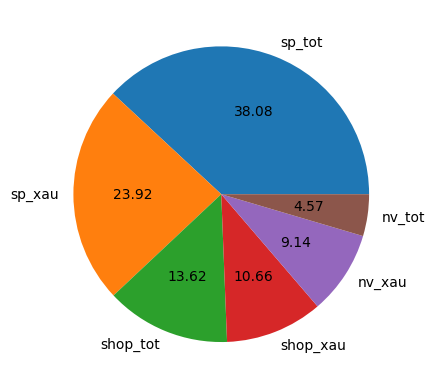

In [10]:
sentiment_counts = df['Sentiment'].value_counts()
# plt.pie(sentiment_counts.to_cupy().get(), labels=sentiment_counts.to_pandas().index, autopct='%0.2f')
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%0.2f')

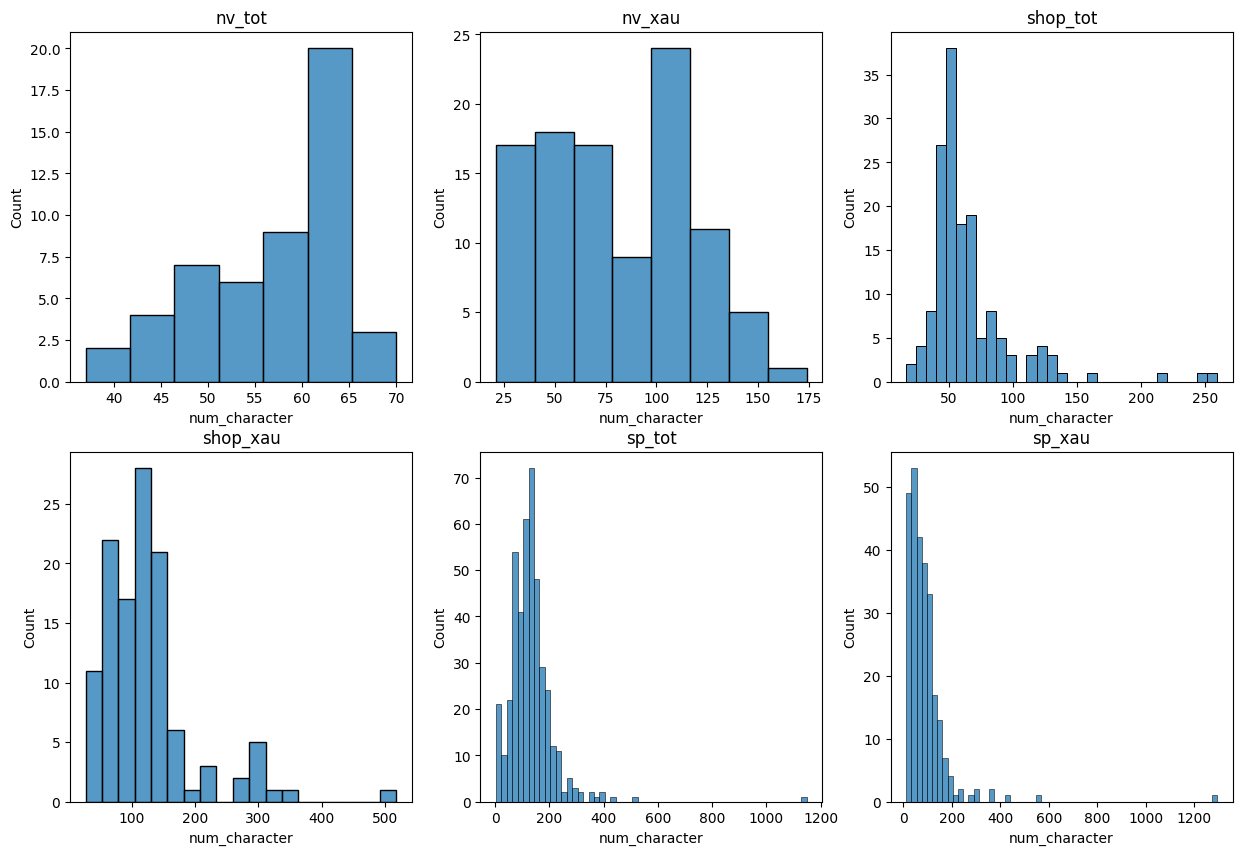

In [11]:
plt.figure(figsize=(15, 10))
# df_pd = df.to_pandas()
for i in range(len(CLASS_NAMES)):
    plt.subplot(2, 3, i+1)
    # sns.histplot(data=df_pd[df_pd['Sentiment']==CLASS_NAMES[i]], x="num_character")
    sns.histplot(data=df[df['Sentiment']==CLASS_NAMES[i]], x="num_character")
    plt.title(CLASS_NAMES[i])

<Figure size 1500x500 with 0 Axes>

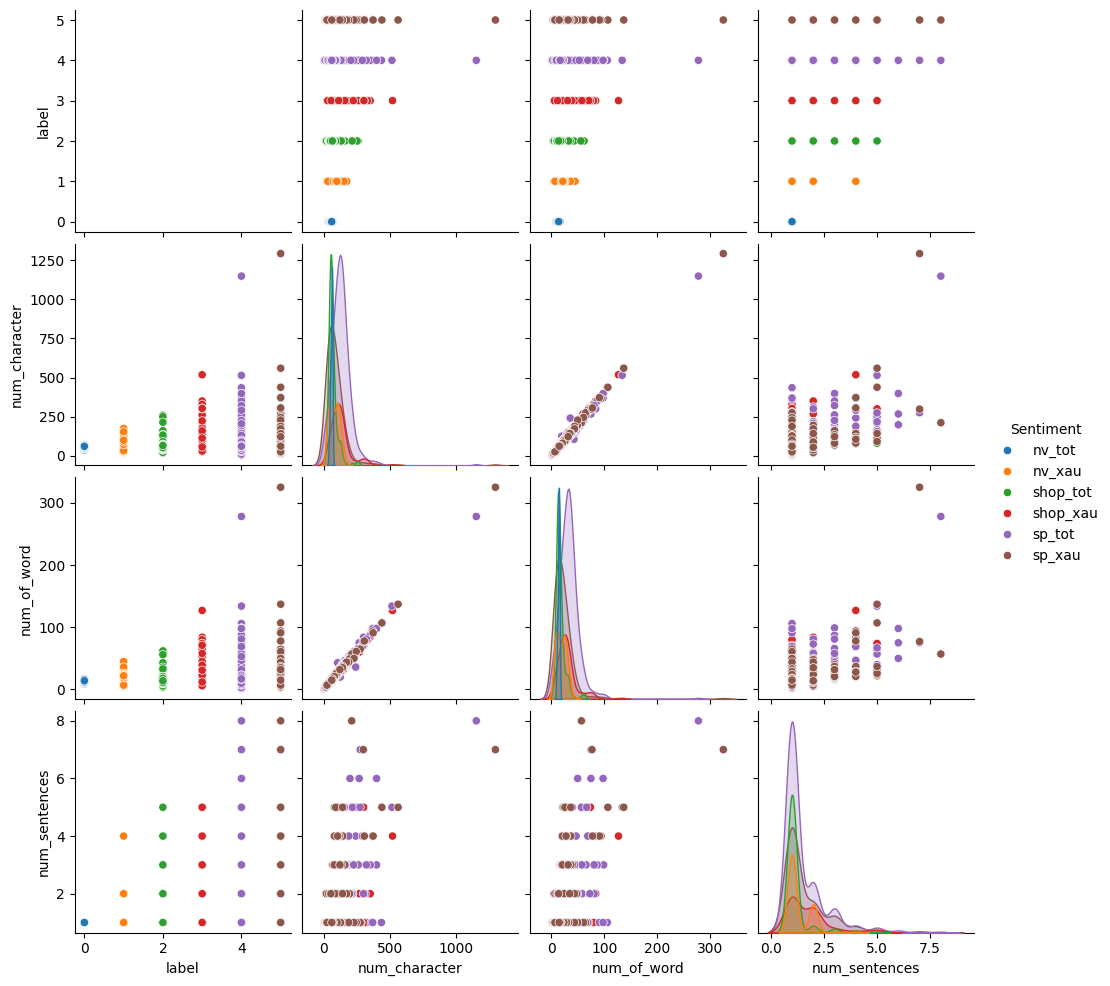

In [12]:
plt.figure(figsize=[15,5])
# sns.pairplot(df.to_pandas(), hue='Sentiment')
sns.pairplot(df, hue='Sentiment')

In [13]:
# list_review = df['Review'].to_list()

In [14]:
# max_length = max(len(x.split(" ")) for x in list_review)
# print(max_length)

In [15]:
# tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')
# tokenizer.pad_token = tokenizer.eos_token
# vocab = tokenizer.get_vocab()

In [16]:
# sequences = tokenizer.batch_encode_plus( list_review,
#     add_special_tokens=True,
#     padding='longest',      
#     truncation=True,         
#     max_length=max_length,            
#     return_tensors='tf',
                                         
# )['input_ids'].numpy()

In [37]:
# docs = [underthesea.word_tokenize(doc.lower()) for doc in df['Review'].to_pandas()]
docs = [underthesea.word_tokenize(doc.lower()) for doc in df['Review']]

sentences = []
for sent in docs:
    k = []
    for w in sent:
        k.append(w.replace(" ", "_"))
    sentences.append(" ".join(k))
    
embeddings = model.encode(sentences,batch_size=31, show_progress_bar=True)

train_texts, val_texts, train_labels, val_labels = train_test_split(embeddings, df['label'], test_size=0.3,
                                                                      random_state=0)
# train_texts2, val_texts2, train_labels2, val_labels2 = train_test_split(sequences, df['label'], test_size=0.3,
#                                                                       random_state=0)
model = load_transformer_model()
# model.to("cuda")


def preprocess(docs):
    return [underthesea.word_tokenize(doc.lower()) for doc in docs]


def get_vocabularies(tokenized_docs):
    vocabs = set()
    for doc in tokenized_docs:
        vocabs.update(doc)
    return vocabs


def identity_tokenizer(text):
    return text

# docs = [underthesea.word_tokenize(doc.lower()) for doc in train_texts.to_pandas()]
# docs = [underthesea.word_tokenize(doc.lower()) for doc in train_texts]

# sentences = []
# for sent in docs:
#     k = []
#     for w in sent:
#         k.append(w.replace(" ", "_"))
#     sentences.append(" ".join(k))
    
# # embeddings = model.encode(sentences,batch_size=31, show_progress_bar=True, device="cuda")
# embeddings = model.encode(sentences,batch_size=31, show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 36/36 [01:42<00:00,  2.86s/it]


True


In [38]:
# # y_train_onehot = keras.utils.to_categorical(train_labels.to_cupy().get(), num_classes=6)
# # y_test_onehot = keras.utils.to_categorical(val_labels.to_cupy().get(), num_classes=6)
# y_train_onehot = keras.utils.to_categorical(train_labels2, num_classes=6)
# y_test_onehot = keras.utils.to_categorical(val_labels2, num_classes=6)

In [39]:
# # x_train = tf.reshape(train_texts.to_pandas(), (*train_texts.shape, 1))
# # x_test = tf.reshape(val_texts.to_pandas(), (*val_texts.shape, 1))
# x_train = tf.reshape(train_texts2, (*train_texts2.shape, 1))
# x_test = tf.reshape(val_texts2, (*val_texts2.shape, 1))

In [40]:
# print("Initial GPU Usage")
# gpu_usage()    

In [42]:
clf2 = SVC(probability=True, max_iter=-1).fit(train_texts, train_labels)

In [43]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).batch(8).cache().shuffle(buffer_size=len(x_train)//8)
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(8).cache().shuffle(buffer_size=len(x_test)//8)

In [44]:
# for batch in train_ds.take(1):
#     for seq, label in zip(batch[0], batch[1]):
#         seq = seq.numpy()
#         label = label.numpy().argmax()
#         review =  tokenizer.decode(seq.reshape(max_length, ), skip_special_tokens=True)
#         sentiment = CLASS_NAMES[label]
        
#         print(f"{review} => {sentiment}({label})\n")    

In [45]:
tokenized_docs = train_texts[:SIZE_DEMO].astype('U')
tokenized_docs_val = val_texts[:SIZE_DEMO].astype('U')
# tokenized_docs_test = test_texts[:SIZE_DEMO].astype('U')
#
# tfidf = TfidfVectorizer(analyzer="word", tokenizer=identity_tokenizer, token_pattern=None, lowercase=False)
# tfidf = TfidfVectorizer(analyzer="word", tokenizer=underthesea.word_tokenize, token_pattern=None, lowercase=False)
# print(tokenized_docs[:100])
# X_train = tfidf.fit_transform(tokenized_docs)
# print(X_train)
# X_train.shape
# y_train = train_labels[:SIZE_DEMO]
# X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2,
#                                                                                 random_state=0)
# print(sentences)

# clf = LinearSVC().fit(embeddings, y_train)


# clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
# clf = MultinomialNB().fit(X_train, y_train)
# clf = RandomForestClassifier().fit(X_train, y_train)


# def val_process(tfidf, clf):
#     X_val = tfidf.transform(tokenized_docs_val)
#     val_predictions = clf.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))

#     # docs_new = ['God is love', 'OpenGL on the GPU is fast']
#     # X_new_tfidf = tfidf.transform(docs_new)

#     # y_pred = clf.predict(X_new_tfidf)

#     # for doc, category in zip(docs_new, y_pred):
#     #     print('%r => %s' % (doc, category))

#     # X_new_tfidf = tfidf.transform(test_texts)

#     # predicted = clf.predict(X_new_tfidf)

#     # np.mean(predicted == test_labels)

#     param_grid = {
#         'C': [0.1, 1, 10, 100, 1000],
#         # 'max_iter': [1000, 5000, 10000],
#     }

#     # tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

#     # parameters = {
#     #     'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
#     # }

#     # parameters = {
#     #     'max_depth':[3,5,10,None],
#     #               'n_estimators':[10,100,200],
#     #               'max_features':[1,3,5,7],
#     #               'min_samples_leaf':[1,2,3],
#     #               'min_samples_split':[1,2,3]
#     # }

#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(LinearSVC(), param_grid, cv=3, refit=True, scoring='accuracy')

#     # grid_search = GridSearchCV(tree.DecisionTreeClassifier(), tree_param, cv=3, refit = True, scoring='accuracy')

#     # grid_search = GridSearchCV(MultinomialNB(), parameters, cv=3, refit = True, scoring='accuracy')

#     # grid_search = GridSearchCV(RandomForestClassifier(), parameters, cv=3, refit = True, scoring='accuracy')

#     # Fit the grid search
#     grid_search.fit(X_train, train_labels[:SIZE_DEMO])

#     # Best parameters
#     best_params = grid_search.best_params_
#     print(f"Best Parameters: {best_params}")

#     # Evaluate best model on validation set
#     best_model = grid_search.best_estimator_
#     val_predictions = best_model.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy with Best Model: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))


In [47]:


# def val_process2(model, clf):
#     nv_tot_val = val_texts[val_labels[val_labels == "nv_tot"].index]
#     nv_xau_val = val_texts[val_labels[val_labels == "nv_xau"].index]
#     shop_tot_val = val_texts[val_labels[val_labels == "shop_tot"].index]
#     shop_xau_val = val_texts[val_labels[val_labels == "shop_xau"].index]
#     sp_tot_val = val_texts[val_labels[val_labels == "sp_tot"].index]
#     sp_xau_val = val_texts[val_labels[val_labels == "sp_xau"].index]
#     nv_tot_val = nv_tot_val[:2000]
#     nv_tot_val = pd.concat([nv_tot_val, nv_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_xau_val[:2000]])
#     nv_tot_val= pd.concat([nv_tot_val, sp_tot_val[:2000]])
#     nv_tot_val= pd.concat([nv_tot_val, sp_xau_val[:2000]])
#     docs_val = [underthesea.word_tokenize(sent.lower()) for sent in nv_tot_val]
#     sentences_val = []
#     for sent in docs_val:
#         k = []
#         for w in sent:
#             k.append(w.replace(" ", "_"))
#         sentences_val.append(" ".join(k))
#     # print(len(sentences))
#     embeddings_val = model.encode(sentences_val, show_progress_bar=True)
#     # X_val = tfidf.transform(tokenized_docs_val)
#     val_predictions = clf.predict(embeddings_val)
#     # val_predictions = clf.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))


# # val_process(tfidf, clf)

# # val_process2(model, clf)


# def train_demo(df_train, tfidf, clf):
#     for index, row in df_train.iterrows():
#         X_val = tfidf.transform([row['Review']])
#         row['Sentiment'] = str(clf.predict(X_val)).strip('[]\'')
#         print(f"{row['Review']}=>{row['Sentiment']}")


def draw_graph(df):
    df_tmp = df
    df_tmp.loc[df_tmp['Sentiment'] == 'positive', 'Sentiment_num'] = 1
    df_tmp.loc[df_tmp['Sentiment'] == 'negative', 'Sentiment_num'] = 0
    df_tmp.loc[df_tmp['Sentiment'] == 'neutral', 'Sentiment_num'] = 2
    # df_tmp2 = pd.DataFrame({
    #     'Sentiment': df_tmp['Sentiment'],
    #     'Sentiment_num': df_tmp['Sentiment_num']
    # })
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='Sentiment', y='Sentiment_num', data=df_tmp)
    plt.show()


def df_transformer(embeddings):
    # nv_tot = df.loc[df['Sentiment'] == "nv_tot"]
    # nv_xau = df.loc[df['Sentiment'] == "nv_xau"]
    # shop_tot = df.loc[df['Sentiment'] == "shop_tot"]
    # shop_xau = df.loc[df['Sentiment'] == "shop_xau"]
    # sp_tot = df.loc[df['Sentiment'] == "sp_tot"]
    # sp_xau = df.loc[df['Sentiment'] == "sp_xau"]
    # nv_tot = nv_tot[:2000]
    # nv_tot = pd.concat([nv_tot, nv_xau.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, shop_tot.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, shop_xau.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, sp_tot.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, sp_xau.loc[:2000]])
    # docs = [underthesea.word_tokenize(sent.lower()) for sent in nv_tot['Review']]
    # model = load_transformer_model()
    # sentences = []
    # for sent in docs:
    #     k = []
    #     for w in sent:
    #         k.append(w.replace(" ", "_"))
    #     sentences.append(" ".join(k))
    # # print(sentences)
    # embeddings = model.encode(sentences, show_progress_bar=True)
    tsne = TSNE(n_components=3, perplexity=2, random_state=42)
    X_tsne = tsne.fit_transform(embeddings)
    ax = plt.figure(figsize=(12,12)).add_subplot(111, projection ="3d")
    # pallete = sns.color_palette('hsv', 3)
    # sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2], hue=pos['Sentiment'], palette=pallete)
    cmap = ListedColormap(sns.color_palette("hsv", 5))
    # groups = pd.DataFrame(X_tsne, columns=['x', 'y', 'z']).assign(category=nv_tot['Sentiment'])
    print(f'{X_tsne.shape}')
    # cdict = {'positive': 'red', 'negative': 'blue', 'neutral': 'green'}
    # for sen in pos['Sentiment'].unique():
    sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=X_tsne[:, 0], cmap=cmap, alpha=0.8)


    plt.title("truc quan hoa du lieu tuyen tinh")
    # plt.legend(*sc.legend_elements())
    # legend1 = ax.legend(*[sc.legend_elements()[0], pos['Sentiment']],
    #                     title="Legend")
    # ax.add_artist(legend1)
    # ax.legend()
    plt.show()


# def df_tfidf(df):
#     pos = df.loc[df['Sentiment'] == "positive"]
#     neg = df.loc[df['Sentiment'] == "negative"]
#     neu = df.loc[df['Sentiment'] == "neutral"]
#     pos = pd.concat([pos, pos.loc[:200]])
#     pos = pd.concat([pos, neg.loc[:200]])
#     pos = pd.concat([pos, neu.loc[:200]])
#     # docs = [underthesea.word_tokenize(sent.lower()) for sent in pos['Review']]
#     # model = None
#     # if not load_transformer_model():
#     #     model = SentenceTransformer('model')
#     # sentences = []
#     # for sent in docs:
#     #     k = []
#     #     for w in sent:
#     #         k.append(w.replace(" ", "_"))
#     #     sentences.append(" ".join(k))
#     # print(sentences)
#     # embeddings = model.encode(sentences, show_progress_bar=True)
#     X_tfidf = tfidf.fit_transform(pos['Review'])
#     pca = PCA(n_components=2).fit_transform(X_tfidf.todense())
#     # X_tsne = pca.transform(X_tfidf.toarray())
#     plt.figure(figsize=(6,4))
#     pallete = sns.color_palette('hsv', 3)
#     sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=pos['Sentiment'], palette=pallete)
#
#     plt.title("truc quan hoa du lieu tuyen tinh")
#     plt.show()


def SVC_model(clf2, X_train2, y_train2, model):
    # clf2 = SVC(probability=True, max_iter=10).fit(embeddings2, y_train2)
    # scores = cross_val_score(clf2, embeddings2, y_train2.to_cupy().get(), cv=10)
    scores = cross_val_score(clf2, X_train2, y_train2, cv=10)
    print(scores)
#     nv_tot_val = val_texts[val_labels[val_labels == "nv_tot"].index]
#     nv_xau_val = val_texts[val_labels[val_labels == "nv_xau"].index]
#     shop_tot_val = val_texts[val_labels[val_labels == "shop_tot"].index]
#     shop_xau_val = val_texts[val_labels[val_labels == "shop_xau"].index]
#     sp_tot_val = val_texts[val_labels[val_labels == "sp_tot"].index]
#     sp_xau_val = val_texts[val_labels[val_labels == "sp_xau"].index]
#     nv_tot_val = nv_tot_val[:2000]
#     nv_tot_val = pd.concat([nv_tot_val, nv_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, sp_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, sp_xau_val[:2000]])
#     docs_val = remove_stop_words(nv_tot_val, stopwords)
    # docs_val = [underthesea.word_tokenize(sent.lower()) for sent in val_texts.to_pandas()]
    # docs_val = [underthesea.word_tokenize(sent.lower()) for sent in val_texts]
    # sentences_val = []
    # for sent in docs_val:
    #     k = []
    #     for w in sent:
    #         k.append(w.replace(" ", "_"))
    #     sentences_val.append(" ".join(k))
    # # print(len(sentences))
    # embeddings_val = model.encode(sentences_val, batch_size=31, show_progress_bar=True)
    # X_val = tfidf.transform(tokenized_docs_val)
    val_predictions = clf2.predict(val_texts)
    # val_predictions = clf.predict(X_val)
    # val_accuracy = accuracy_score(val_labels.to_cupy().get(), val_predictions)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    # print(classification_report(val_labels.to_cupy().get(), val_predictions))
    print(classification_report(val_labels, val_predictions))


# draw_graph(df)


# df_tfidf(df)

# df_transformer(embeddings)

SVC_model(clf2, train_texts, train_labels, model)

[0.91139241 0.85897436 0.92307692 0.88461538 0.85897436 0.88461538
 0.82051282 0.88461538 0.8974359  0.88461538]
Validation Accuracy: 0.8925
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.90      0.86      0.88        22
           2       0.88      0.86      0.87        42
           3       0.88      0.73      0.80        30
           4       0.92      0.93      0.93       140
           5       0.86      0.91      0.89        89

    accuracy                           0.89       335
   macro avg       0.88      0.87      0.87       335
weighted avg       0.89      0.89      0.89       335



In [ ]:
# def plot_multiclass_roc(model, test_dataset, n_classes):
    
#     y_true = []
#     y_pred = []
    
#     for feature, labels in test_dataset:
#         print(feature)
#         y_true.append(labels.numpy())
#         y_pred.append(model.predict(feature.reshape(feature.shape[0],-1)))
    
#     y_true = np.concatenate(y_true)
#     y_pred = np.concatenate(y_pred)

    
#     if y_true.ndim == 1 or y_true.shape[1] != n_classes:
#         y_true = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

    
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
    
#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])


#     fig, axes = plt.subplots(2, 3, figsize=(20, 15))
#     axes = axes.ravel()

#     for i in range(n_classes):
#         axes[i].plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
#         axes[i].plot([0, 1], [0, 1], 'k--')
#         axes[i].set_xlim([0.0, 1.0])
#         axes[i].set_ylim([0.0, 1.05])
#         axes[i].set_xlabel('False Positive Rate')
#         axes[i].set_ylabel('True Positive Rate')
#         axes[i].set_title(f'ROC Curve for {CLASS_NAMES[i]}')
#         axes[i].legend(loc="lower right")
    
#     # Hide any unused subplots if n_classes < 6
#     for i in range(n_classes, len(axes)):
#         fig.delaxes(axes[i])
    
#     plt.tight_layout()
#     plt.show()
# plot_multiclass_roc(clf2, test_ds, len(CLASS_NAMES))

In [ ]:
# def plot_confusion_matrix(cm, class_names):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()
# def visualize_confusion_matrix(model, dataset, class_names):
    
#     true_labels = []
#     predictions = []
    
#     for features, labels in dataset:
#         preds = model.predict(features)
#         true_labels.extend(labels.numpy())
#         predictions.extend(np.argmax(preds, axis=1))
    
#     if len(true_labels) > 0 and len(true_labels[0]) > 1:
#         true_labels = np.argmax(true_labels, axis=1)
    
#     cm = confusion_matrix(true_labels, predictions)
    
#     plot_confusion_matrix(cm, class_names)
    
    
# visualize_confusion_matrix(clf2, test_ds, CLASS_NAMES)

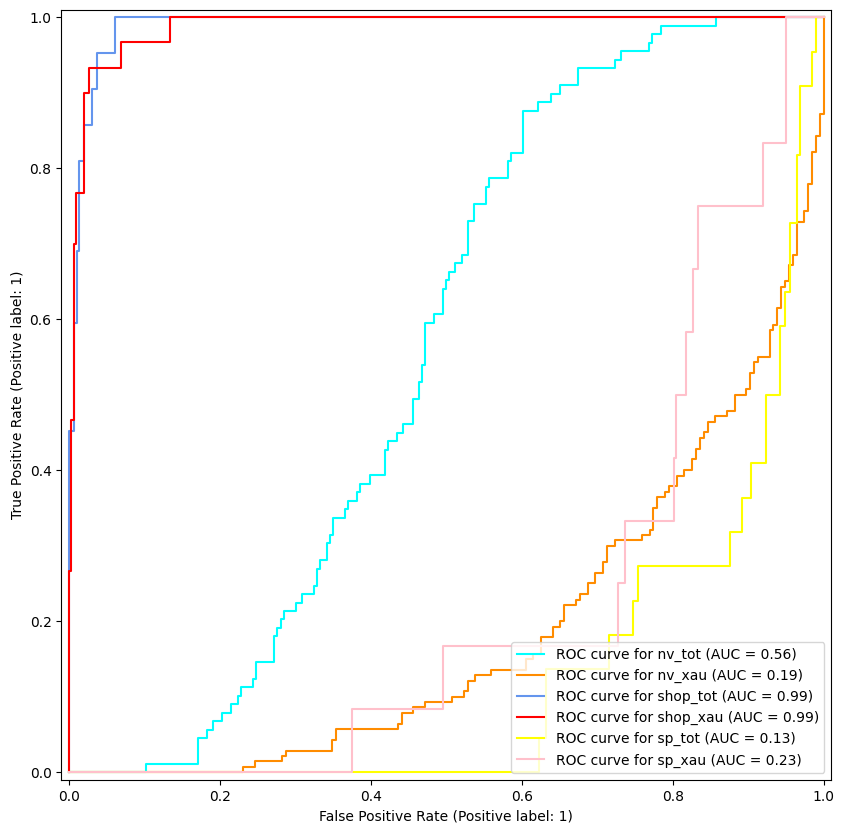

In [85]:
def ROC_curve_SVC(svc, X_test, y_test, class_names):
    # ax = plt.gca()
    # rfc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax, alpha=0.8)
    # svc_disp.plot(ax=ax, alpha=0.8)
    # plt.show()
    # predicted = svc.predict(X_test)
    predicted_proba = svc.predict_proba(X_test)
    # roc_auc = roc_auc_score(y_test, predicted_proba, multi_class='ovr')
    # print(roc_auc)
    target = label_binarize(y_test,
                        classes=pd.unique(y_test))
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "yellow", "pink"])
    for class_id, color in zip(range(len(pd.unique(df['label']))), colors):
        RocCurveDisplay.from_predictions(
            target[:, class_id],
            predicted_proba [:, class_id],
            name=f"ROC curve for {class_names[class_id]}",
            color=color,
            ax=ax,
        )
    

ROC_curve_SVC(clf2, val_texts, val_labels, CLASS_NAMES)

Confusion matrix, without normalization
[[ 11   1   0   0   0   0]
 [  0  19   0   2   0   1]
 [  2   1  36   0   3   0]
 [  0   0   0  22   1   7]
 [  0   0   4   1 130   5]
 [  0   0   1   0   7  81]]
Normalized confusion matrix
[[0.91666667 0.08333333 0.         0.         0.         0.        ]
 [0.         0.86363636 0.         0.09090909 0.         0.04545455]
 [0.04761905 0.02380952 0.85714286 0.         0.07142857 0.        ]
 [0.         0.         0.         0.73333333 0.03333333 0.23333333]
 [0.         0.         0.02857143 0.00714286 0.92857143 0.03571429]
 [0.         0.         0.01123596 0.         0.07865169 0.91011236]]


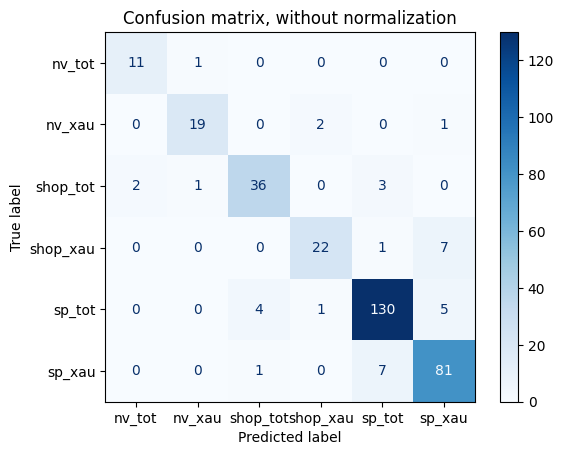

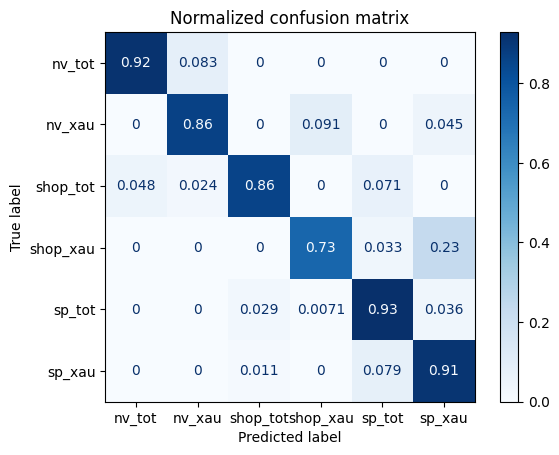

In [70]:
# def plot_confusion_matrix(cm, class_names):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()
# def visualize_confusion_matrix(clf2, model, dataset, test_labels, class_names):
    
#     true_labels = test_labels
#     predictions = []

#     # print(type(test_labels))
    
#     for idx, value in enumerate(dataset):
#         # print(type(test_labels.iloc[idx]))
#         preds = clf2.predict([value])
#         # true_labels.extend(test_labels.iloc[idx].to_numpy())
#         predictions.extend(np.argmax(preds, axis=1))
    
#     if true_labels.size > 0 and true_labels.iloc[0].size > 1:
#         true_labels = np.argmax([true_labels], axis=1)
    
#     cm = confusion_matrix(true_labels, predictions)
    
#     plot_confusion_matrix(cm, class_names)
    
    
# visualize_confusion_matrix(clf2, model, val_texts, val_labels, CLASS_NAMES)

def confusion_matrix_svc(clf2, X_test, y_test, class_names):
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf2,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
    
        print(title)
        print(disp.confusion_matrix)
    
    plt.show()

confusion_matrix_svc(clf2, val_texts, val_labels, CLASS_NAMES)